In [1]:
import sys
sys.path.append('../atac_rna/')

import numpy as np
import pickle
import os
import pandas as pd

import time

import scanpy
import numpy as np

import torch
from torch import optim

import model_lord

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import anndata as ad



In [2]:
snl111=ad.read('/data/xinyi/c2p/citeseq_totalvi/totalVI_reproducibility/data/spleen_lymph_111.h5ad')
#same preprocessing as totalVI for proteins and highly variable genes
snl111_rna=snl111[:,snl111.var["hvg_encode"]]
rna=snl111_rna.X.toarray()

#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(rna.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*rna.shape[0])]
testIdx_all=allIdx_all[int(pctVal*rna.shape[0]):(int(pctVal*rna.shape[0])+int(pctTest*rna.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*rna.shape[0])+int(pctTest*rna.shape[0])):]

#preprocess rna
rna_posweight=(rna[trainIdx_all].size-np.sum(rna[trainIdx_all]))/np.sum(rna[trainIdx_all])
#preprocess
rna=np.log(rna+1/2)
rna=(rna-np.min(rna,axis=1,keepdims=True))/(np.max(rna,axis=1,keepdims=True)-np.min(rna,axis=1,keepdims=True))

#preprocess protein
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in snl111.uns["protein_names"]]
)

snl111.obsm["protein_expression"] = snl111.obsm["protein_expression"][
    :, keep_pro_111
]
snl111.uns["protein_names"] = snl111.uns["protein_names"][keep_pro_111]

protein=np.array(snl111.obsm["protein_expression"])

#preprocess protein
protein_posweight=(protein[trainIdx_all].size-np.sum(protein[trainIdx_all]>0))/np.sum(protein[trainIdx_all]>0)
#preprocess
protein=np.log(protein+1/2)
protein=(protein-np.min(protein,axis=1,keepdims=True))/(np.max(protein,axis=1,keepdims=True)-np.min(protein,axis=1,keepdims=True))

log_data=True
normalize='minmax'
hiddenSize=1024
sharedSize=50
dSpecificSize=30
seed=1


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
 
match_weight=100

batchsize=512
saveFreq=200
epochs=5000
lr=0.00001
weight_decay=0

dropout=0.01
kl_weight=0.0000001

addNoise=True
actDecay=0.001

testSaveName='vae_bce'
name='test1_bothdays'
#test0 match_weight=1
#test1 match_weight=100
logsavepath=os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/plots',testSaveName,name)

loss_x_rna=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(rna_posweight).cuda())
loss_x_protein=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(protein_posweight).cuda())

In [4]:
if not os.path.exists(os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/plots',testSaveName)):
    os.mkdir(os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/plots',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/models',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/c2p/citeseq_totalvi/results/log',testSaveName))
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)
nFeatures_rna=rna.shape[1]
nFeatures_protein=protein.shape[1]

In [5]:
def train(epoch,exprs,trainIdx,valIdx,latentp,model_train,loss_x,optimizer_train):
    t = time.time()
    model_train.train()

    loss_kl_train_all=0
    loss_x_train_all=0
    loss_match_train_all=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(exprs[trainIdx_i])

        trainInput=trainInput.cuda().float()
        optimizer_train.zero_grad()

        recon, z, mu, logvar = model_train(trainInput)
        
        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        if latentp is not None:
            loss_match_train=loss_match(z,latentp[trainIdx_i])
        else:
            loss_match_train=0
        loss=loss_kl_train*kl_weight+loss_x_train+loss_match_train*match_weight

        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        if latentp is not None:
            loss_match_train_all+=loss_match_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizer_train.step()


    loss_kl_train_all=loss_kl_train_all/ntrainBatches
    loss_x_train_all=loss_x_train_all/ntrainBatches
    loss_match_train_all=loss_match_train_all/ntrainBatches
    loss_all=loss_all/ntrainBatches

    with torch.no_grad():
        model_train.eval()

        loss_val_all=0
        loss_x_val_all=0
        loss_match_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(exprs[valIdx_i])
            valInput=valInput.cuda().float()
            recon,z, mu, logvar = model_train(valInput)

            loss_x_val=loss_x(recon, valInput).item()
            if latentp is not None:
                loss_match_val=loss_match(z,latentp[valIdx_i]).item()
            else:
                loss_match_val=0
            loss_val=loss_x_val+loss_match_val*match_weight

            loss_x_val_all+=loss_x_val
            if latentp is not None:
                loss_match_val_all+=loss_match_val
            loss_val_all+=loss_val

        loss_x_val_all=loss_x_val_all/nvalBatches
        loss_match_val_all=loss_match_val_all/nvalBatches
        loss_val_all=loss_val_all/nvalBatches

        latent_curr=None
        nplotBatches=int(np.ceil(exprs.shape[0]/batchsize))
        for i in range(nplotBatches):
            plotInput=torch.tensor(exprs[i*batchsize:min((i+1)*batchsize,exprs.shape[0])])
            plotInput=plotInput.cuda().float()
            recon,z, mu, logvar = model_train(plotInput)
            if latent_curr is None:
                latent_curr=z.detach()
            else:
                latent_curr=torch.cat((latent_curr,z.detach()),0)
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_match_train: {:.4f}'.format(loss_match_train_all),
          'loss_x_val: {:.4f}'.format(loss_x_val_all),
          'loss_match_val: {:.4f}'.format(loss_match_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return latent_curr,loss_all,loss_kl_train_all,loss_x_train_all,loss_match_train_all,loss_val_all,loss_x_val_all,loss_match_val_all

In [6]:
class FCVAE(torch.nn.Module): 
    def __init__(self, input_feat_dim, hidden_dim1, hidden_dim2,hidden_dim3,hidden_dim4,fc_dim1,fc_dim2,fc_dim3, dropout):
        super(FCVAE, self).__init__()
        self.fcE1 = gae.gae.layers.FC(input_feat_dim,hidden_dim1, dropout)
        self.fcE2 = gae.gae.layers.FC(hidden_dim1, hidden_dim2, dropout)
        self.fcE3 = gae.gae.layers.FC(hidden_dim2, hidden_dim3, dropout)
        self.fcE4 = gae.gae.layers.FC(hidden_dim3, hidden_dim4, dropout, act=lambda x: x, batchnorm = False)
        self.fcE4s = gae.gae.layers.FC(hidden_dim3, hidden_dim4, dropout, act=lambda x: x, batchnorm = False)
        self.fcD1 = gae.gae.layers.FC(hidden_dim4,fc_dim1, dropout)
        self.fcD2 = gae.gae.layers.FC(fc_dim1, fc_dim2, dropout)
        self.fcD3 = gae.gae.layers.FC(fc_dim2, fc_dim3, dropout)
        self.fcD4 = gae.gae.layers.FC(fc_dim3, input_feat_dim, dropout, act = lambda x: x, batchnorm = False)

    def encode(self, x):
        hidden = self.fcE1(x)
        hidden = self.fcE2(hidden)
        hidden = self.fcE3(hidden)
        return self.fcE4(hidden),self.fcE4s(hidden)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode_X(self,z):
        output = self.fcD1(z)
        output = self.fcD2(output)
        output = self.fcD3(output)
        output = self.fcD4(output)
        return output
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode_X(z), z, mu, logvar

50
Epoch: 0000 loss_train: 0.7088 loss_kl_train: 0.0000 loss_x_train: 0.7088 loss_match_train: 0.0000 loss_x_val: 0.7134 loss_match_val: 0.0000 time: 1.2669s
Epoch: 0000 loss_train: 97.9314 loss_kl_train: 0.0001 loss_x_train: 0.4691 loss_match_train: 0.9746 loss_x_val: 0.4767 loss_match_val: 0.0004 time: 0.1568s
Epoch: 0001 loss_train: 100.8532 loss_kl_train: 0.0000 loss_x_train: 0.6930 loss_match_train: 1.0016 loss_x_val: 0.7132 loss_match_val: 0.0004 time: 0.5712s
Epoch: 0001 loss_train: 92.3313 loss_kl_train: 0.0004 loss_x_train: 0.4506 loss_match_train: 0.9188 loss_x_val: 0.4760 loss_match_val: 0.0007 time: 0.1544s
Epoch: 0002 loss_train: 97.2361 loss_kl_train: 0.0001 loss_x_train: 0.6477 loss_match_train: 0.9659 loss_x_val: 0.7109 loss_match_val: 0.0008 time: 0.8355s
Epoch: 0002 loss_train: 81.8508 loss_kl_train: 0.0020 loss_x_train: 0.4180 loss_match_train: 0.8143 loss_x_val: 0.4735 loss_match_val: 0.0011 time: 0.1629s
Epoch: 0003 loss_train: 83.7615 loss_kl_train: 0.0021 loss_x_

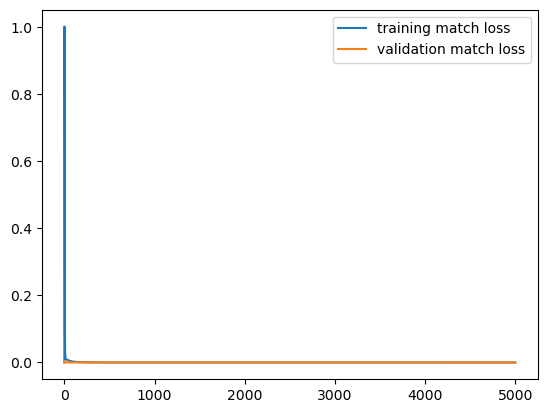

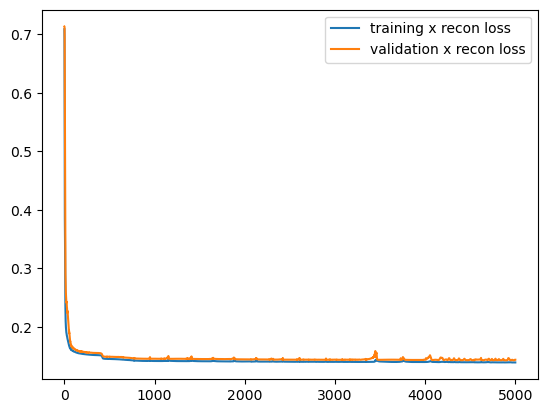

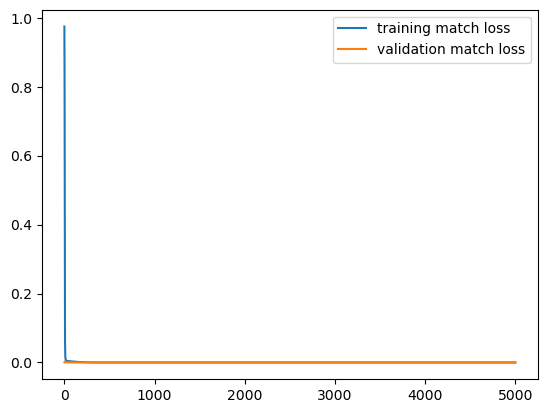

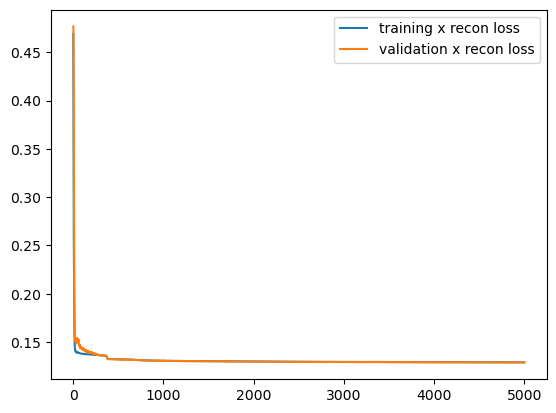

In [7]:

logsavepath_p_rna=os.path.join(logsavepath,'rna')
modelsavepath_p_rna=os.path.join(modelsavepath,'rna')
plotsavepath_p_rna=os.path.join(plotsavepath,'rna')
if not os.path.exists(logsavepath_p_rna):
    os.mkdir(logsavepath_p_rna)
if not os.path.exists(modelsavepath_p_rna):
    os.mkdir(modelsavepath_p_rna)
if not os.path.exists(plotsavepath_p_rna):
    os.mkdir(plotsavepath_p_rna)

logsavepath_p_protein=os.path.join(logsavepath,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath,'protein')
if not os.path.exists(logsavepath_p_protein):
    os.mkdir(logsavepath_p_protein)
if not os.path.exists(modelsavepath_p_protein):
    os.mkdir(modelsavepath_p_protein)
if not os.path.exists(plotsavepath_p_protein):
    os.mkdir(plotsavepath_p_protein)

#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(rna.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*rna.shape[0])]
testIdx_all=allIdx_all[int(pctVal*rna.shape[0]):(int(pctVal*rna.shape[0])+int(pctTest*rna.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*rna.shape[0])+int(pctTest*rna.shape[0])):]



currLatentSize=sharedSize
latent_curr=None

print(currLatentSize)

loss_match=torch.nn.MSELoss()
loss_kl=optimizer.optimizer_kl

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
modelcnn_rna = FCVAE(nFeatures_rna, hiddenSize, hiddenSize,hiddenSize,sharedSize+dSpecificSize,hiddenSize,hiddenSize,hiddenSize, dropout)
modelcnn_protein = FCVAE(nFeatures_protein, hiddenSize, hiddenSize,hiddenSize,sharedSize+dSpecificSize,hiddenSize,hiddenSize,hiddenSize, dropout)
modelcnn_rna.cuda()
modelcnn_protein.cuda()

optimizer_rna = torch.optim.Adam(modelcnn_rna.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_protein = torch.optim.Adam(modelcnn_protein.parameters(), lr=lr, weight_decay=weight_decay)

train_loss_rna=[np.inf]*(epochs)
train_loss_kl_rna=[np.inf]*(epochs)
train_loss_x_rna=[np.inf]*(epochs)
train_loss_match_rna=[np.inf]*(epochs)
val_loss_rna=[np.inf]*(epochs)
val_loss_x_rna=[np.inf]*(epochs)
val_loss_match_rna=[np.inf]*(epochs)

train_loss_protein=[np.inf]*(epochs)
train_loss_kl_protein=[np.inf]*(epochs)
train_loss_x_protein=[np.inf]*(epochs)
train_loss_match_protein=[np.inf]*(epochs)
val_loss_protein=[np.inf]*(epochs)
val_loss_x_protein=[np.inf]*(epochs)
val_loss_match_protein=[np.inf]*(epochs)

t_ep=time.time()

stateDict_train_rna={}
stateDict_train_protein={}



latent_curr=None
epCounts=0
for ep in range(epochs):
    latent_curr,train_loss_rna[ep],train_loss_kl_rna[ep],train_loss_x_rna[ep],train_loss_match_rna[ep],val_loss_rna[ep],val_loss_x_rna[ep],val_loss_match_rna[ep]=train(ep,rna,trainIdx_all,valIdx_all,latent_curr,modelcnn_rna,loss_x_rna,optimizer_rna)
    latent_curr,train_loss_protein[ep],train_loss_kl_protein[ep],train_loss_x_protein[ep],train_loss_match_protein[ep],val_loss_protein[ep],val_loss_x_protein[ep],val_loss_match_protein[ep]=train(ep,protein,trainIdx_all,valIdx_all,latent_curr,modelcnn_protein,loss_x_protein,optimizer_protein)


    if ep%saveFreq == (saveFreq-1):
        stateDict_train_rna[ep]=modelcnn_rna.cpu().state_dict()
        stateDict_train_protein[ep]=modelcnn_protein.cpu().state_dict()


    modelcnn_rna.cuda()
    modelcnn_protein.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))

with open(os.path.join(modelsavepath_p_rna,'stateDict_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(stateDict_train_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(stateDict_train_protein, output, pickle.HIGHEST_PROTOCOL)

with open(os.path.join(logsavepath_p_rna,'train_loss_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_rna,'train_loss_kl_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_kl_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_rna,'train_loss_x_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_x_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_rna,'train_loss_match_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_match_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_rna,'val_loss_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(val_loss_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_rna,'val_loss_x_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(val_loss_x_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_rna,'val_loss_match_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(val_loss_match_rna, output, pickle.HIGHEST_PROTOCOL)

with open(os.path.join(logsavepath_p_protein,'train_loss_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_protein, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_protein,'train_loss_kl_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_kl_protein, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_protein,'train_loss_x_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_x_protein, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_protein,'train_loss_match_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(train_loss_match_protein, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_protein,'val_loss_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(val_loss_protein, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_protein,'val_loss_x_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(val_loss_x_protein, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath_p_protein,'val_loss_match_'+str(currLatentSize)), 'wb') as output:
    pickle.dump(val_loss_match_protein, output, pickle.HIGHEST_PROTOCOL)

totalepoch=np.argmin(np.array(val_loss_x_rna)+np.array(val_loss_x_protein)+np.array(val_loss_match_protein))

print('loss_val_p: {:.4f}'.format(val_loss_x_protein[totalepoch]),
      'loss_val_c: {:.4f}'.format(val_loss_x_rna[totalepoch]),
      'loss_val_match: {:.4f}'.format(val_loss_match_rna[totalepoch]))

plt.plot(np.arange(epochs),train_loss_match_rna)
plt.plot(np.arange(epochs),val_loss_match_rna)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training match loss','validation match loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath_p_rna,'loss_seed3_match'+str(currLatentSize)+'.jpg'))
plt.show()


plt.plot(np.arange(epochs),train_loss_x_rna)
plt.plot(np.arange(epochs),val_loss_x_rna)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath_p_rna,'loss_seed3_x'+str(currLatentSize)+'.jpg'))
plt.show()

plt.plot(np.arange(epochs),train_loss_match_protein)
plt.plot(np.arange(epochs),val_loss_match_protein)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training match loss','validation match loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath_p_protein,'loss_seed3_match'+str(currLatentSize)+'.jpg'))
plt.show()

plt.plot(np.arange(epochs),train_loss_x_protein)
plt.plot(np.arange(epochs),val_loss_x_protein)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath_p_protein,'loss_seed3_x'+str(currLatentSize)+'.jpg'))
plt.show()









In [17]:
ep=4999
modelcnn_rna = FCVAE(nFeatures_rna, hiddenSize, hiddenSize,hiddenSize,sharedSize+dSpecificSize,hiddenSize,hiddenSize,hiddenSize, dropout)
modelcnn_protein = FCVAE(nFeatures_protein, hiddenSize, hiddenSize,hiddenSize,sharedSize+dSpecificSize,hiddenSize,hiddenSize,hiddenSize, dropout)
modelcnn_rna.cuda()
modelcnn_protein.cuda()

with open(os.path.join(modelsavepath_p_rna,'stateDict_'+str(sharedSize)), 'rb') as output:
    stateDict_train_rna=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(sharedSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

modelcnn_rna.load_state_dict(stateDict_train_rna[ep])
modelcnn_protein.load_state_dict(stateDict_train_protein[ep])

<All keys matched successfully>

In [18]:
with torch.no_grad():
    modelcnn_rna.eval()

    latent_rna=None
    nplotBatches=int(np.ceil(rna.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(rna[i*batchsize:min((i+1)*batchsize,rna.shape[0])])
        plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn_rna(plotInput)
        if latent_rna is None:
            latent_rna=z.detach()
        else:
            latent_rna=torch.cat((latent_rna,z.detach()),0)

In [19]:
with torch.no_grad():
    modelcnn_protein.eval()

    latent_protein=None
    nplotBatches=int(np.ceil(protein.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(protein[i*batchsize:min((i+1)*batchsize,protein.shape[0])])
        plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn_protein(plotInput)
        if latent_protein is None:
            latent_protein=z.detach()
        else:
            latent_protein=torch.cat((latent_protein,z.detach()),0)

In [20]:
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None,ncolors=None,colorseq=None,s=2.5):
    
    celltypes=np.unique(ctlist)
    if ncolors is None:
        colortest=sns.color_palette("husl", celltypes.size)
        if colorseq is None:
            colorseq=np.arange(celltypes.size)
    else:
        colortest=sns.color_palette("husl", ncolors)
        if colorseq is None:
            colorseq=np.arange(ncolors)

    
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
                color=colortest[colorseq[int(ct)]],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
                color=colortest[colorseq[int(ct)]],label=ct,s=s,alpha=1
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=5, shadow=True,prop={'size': 6})
    plt.title(plotname+' embedding', fontsize=12)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.pdf'))
    
    plt.close('all')
    
def plotembeddingbyCT_str(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=1,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(6)
    fig.set_figwidth(6)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.3,
                     box.width, box.height * 0.7])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
              fancybox=True, ncol=3, shadow=True, prop={'size': 6})
    plt.title(plotname, fontsize=12)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.pdf'))
    plt.close('all')
    
    gc.collect()

In [21]:
#plot latent
n_neighbors=10
min_dist=0.25

reducer_rnalatent = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=3).fit(latent_rna.cpu().numpy())
reducer_proteinlatent = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=3).fit(latent_protein.cpu().numpy())

In [22]:
ct_top3=np.copy(snl111_rna.obs['cell_types'])
for ct in np.unique(ct_top3):
    if ct=='Activated CD4 T':
        ct_top3[ct_top3==ct]='CD4+'
    if ct=='B doublets' or ct=='Low quality B cells':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='CD122+ CD8 T':
        ct_top3[ct_top3==ct]='CD8+'
    if ct=='CD4 T':
        ct_top3[ct_top3==ct]='CD4+'
    if ct=='CD8 T':
        ct_top3[ct_top3==ct]='CD8+'
    if ct=='Mature B':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='Plasma B':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='Transitional B':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='MZ B':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='B1 B':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='Ifit3-high B':
        ct_top3[ct_top3==ct]='B cells'
    if ct=='Ifit3-high CD4 T':
        ct_top3[ct_top3==ct]='CD4+'
    if ct=='Ifit3-high CD8 T':
        ct_top3[ct_top3==ct]='CD8+'
    if 'mono' in ct or 'DC' in ct:
        ct_top3[ct_top3==ct]='myeloid'
    if ct=='MZ/Marco-high macrophages' or ct=='Red-pulp macrophages':
        ct_top3[ct_top3==ct]='myeloid'
    elif ct not in ['Neutrophils']:
        ct_top3[ct_top3==ct]='others'
plotembeddingbyCT_str(ct_top3,'celltypeTop3_rna_latent',[],reducer_rnalatent.embedding_,plotsavepath,'cell type',plotdimx=0,plotdimy=1,savenameAdd='_'+str(sharedSize)+'_'+str(hiddenSize)+'_'+str(seed))
    

In [23]:
plotembeddingbyCT_str(ct_top3,'celltypeTop3_protein_latent',[],reducer_proteinlatent.embedding_,plotsavepath,'cell type',plotdimx=0,plotdimy=1,savenameAdd='_'+str(sharedSize)+'_'+str(hiddenSize)+'_'+str(seed))


In [24]:
plotembeddingbyCT_str(np.array(snl111_rna.obs['batch_indices']),'batch_rna_latent',[],reducer_rnalatent.embedding_,plotsavepath,'batch',plotdimx=0,plotdimy=1,savenameAdd='_'+str(sharedSize)+'_'+str(hiddenSize)+'_'+str(seed))


In [25]:
plotembeddingbyCT_str(np.array(snl111_rna.obs['batch_indices']),'batch_protein_latent',[],reducer_proteinlatent.embedding_,plotsavepath,'batch',plotdimx=0,plotdimy=1,savenameAdd='_'+str(sharedSize)+'_'+str(hiddenSize)+'_'+str(seed))
